In [1]:
### Match Outcome Predictor Using Machine Learning
# In this notebook, we will develop a match outcome predictor by applying various machine learning algorithms and feature engineering techniques. The goal is to build a model that accurately forecasts match results based on available data.

# To achieve this, we will:

# Experiment with different algorithms, including Random Forests, Linear Regression, and others, to assess which model performs best.
# Utilize feature engineering to transform and enhance the data, improving model performance and interpretability.


In [2]:
# imports 
import pandas as pd 
import os
import numpy as np 


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation and metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

# For handling warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# lets look at our current data 
team_data = [
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/big_chance_missed_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/big_chance_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/clean_sheet_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/corner_taken_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/expected_goals_conceded_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/expected_goals_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/fk_foul_lost_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/goals_conceded_team_match.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/possession_percentage_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/possession_won_att_3rd_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/team_ratings.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/touches_in_opp_box_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/total_red_card_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/won_tackle_team.csv"
]

player_data = [
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_big_chances_created.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_expected_assists_per_90.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_expected_goals_per_90.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_penalties_conceded.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_player_ratings.csv",
]

In [4]:
# lets put them into dataframes 

team_dataframes = []
player_dataframes = []
results_dataframes = []

for path in team_data: 
    dataframe = pd.read_csv(path, index_col=0, sep=",")
    dataframe.drop(columns=['Matches', 'Country'], axis=1, inplace=True)
    team_dataframes.append(dataframe)

for path in player_data:
    dataframe = pd.read_csv(path, index_col=0, sep=",")
    dataframe.drop(columns=['Matches', 'Country'], axis=1, inplace=True)
    player_dataframes.append(dataframe)


In [5]:
# lets merge the dataframes together on the Team column, this will ensure all stats align with their associated team 
# ensuring accurate data analysis and an accurate model 

def merge_team_dataframes(dataframes, merge_column='Team'):
    """
    Merge multiple DataFrames with consistent team alignment and unique column names
    
    Parameters:
    dataframes (list): List of pandas DataFrames to merge
    merge_column (str): Column name used for merging (default 'Team')
    
    Returns:
    pandas.DataFrame: Merged DataFrame with all team-level information
    """
    # Validate input
    if not all(merge_column in df.columns for df in dataframes):
        raise ValueError(f"All DataFrames must contain a '{merge_column}' column")
    
    # Generate unique suffixes
    def generate_suffixes(dataframes):
        suffixes = []
        for i, df in enumerate(dataframes):
            suffix = f'_{i+1}'
            # Rename columns to avoid conflicts
            df.columns = [f'{col}{suffix}' if col != merge_column else col for col in df.columns]
            suffixes.append(suffix)
        return suffixes
    
    # Generate unique suffixes for non-merge columns
    generate_suffixes(dataframes)
    
    # Start with the first DataFrame
    merged_df = dataframes[0]
    
    # Progressively merge subsequent DataFrames
    for next_df in dataframes[1:]:
        merged_df = pd.merge(
            merged_df, 
            next_df, 
            on=merge_column, 
            how='outer'  # Keeps all teams even if missing in some DataFrames
        )
    
    # Rename merge column back to original
    merged_df.rename(columns={merge_column: 'Team'}, inplace=True)
    
    return merged_df

stats_df = merge_team_dataframes(team_dataframes)

stats_df.head()

,Team,Big Chances Missed_1,Goals_1,Big Chances_2,Goals_2,Clean Sheets_3,Corners Taken_4,Expected Goals Conceded_5,Goals Conceded_5,Expected Goals_6,...,Total Goals Conceded_8,Possession (%)_9,Possession Won Final 3rd per Match_10,Total Possessions Won_10,FotMob Team Rating_11,Touches in Opposition Box_12,Red Cards_13,Yellow Cards_13,Successful Tackles per Match_14,Tackle Success (%)_14
0,AFC Bournemouth,49.0,54.0,83.0,54.0,9.0,235.0,58.8,67.0,56.7,...,67.0,44.1,5.4,901.0,6.81,1101.0,3.0,79.0,10.8,59.2
1,Arsenal,63.0,91.0,113.0,91.0,18.0,265.0,28.4,29.0,77.4,...,29.0,58.4,6.7,820.0,7.18,1587.0,2.0,62.0,9.2,57.0
2,Aston Villa,58.0,76.0,98.0,76.0,8.0,231.0,60.7,61.0,64.7,...,61.0,53.3,4.1,632.0,6.91,1078.0,2.0,94.0,8.2,56.9
3,Brentford,69.0,56.0,107.0,56.0,7.0,184.0,56.7,65.0,59.8,...,65.0,45.0,4.8,798.0,6.82,1031.0,2.0,89.0,10.5,58.9
4,Brighton & Hove Albion,61.0,55.0,91.0,55.0,6.0,206.0,56.4,62.0,58.0,...,62.0,60.2,4.7,797.0,6.80,1158.0,3.0,91.0,9.6,56.8


In [6]:
def merge_player_dataframes(dataframes, merge_column='Player', 
                     unique_columns=['Team', 'Minutes'], 
                     suffixes=None):
    """
    Merge multiple DataFrames with flexible column handling
    
    Parameters:
    dataframes (list): List of pandas DataFrames to merge
    merge_column (str): Column name used for merging (default 'Player')
    unique_columns (list): Columns to keep only once in the merged DataFrame
    suffixes (list, optional): Custom suffixes for non-unique columns
    
    Returns:
    pandas.DataFrame: Merged DataFrame with controlled column naming
    """
    # Validate input
    if not all(merge_column in df.columns for df in dataframes):
        raise ValueError(f"All DataFrames must contain a '{merge_column}' column")
    
    # Prepare DataFrames
    processed_dfs = []
    for i, df in enumerate(dataframes):
        # Create a copy to avoid modifying original DataFrames
        processed_df = df.copy()
        
        # Separate unique and non-unique columns
        unique_cols = [col for col in unique_columns if col in processed_df.columns]
        non_unique_cols = [col for col in processed_df.columns 
                            if col not in unique_cols and col != merge_column]
        
        # Add suffix to non-unique columns
        if not suffixes:
            suffixes = [f'_{i+1}' for i in range(len(dataframes))]
        
        # Rename non-unique columns
        for col in non_unique_cols:
            processed_df.rename(columns={col: f'{col}{suffixes[i]}'}, inplace=True)
        
        processed_dfs.append(processed_df)
    
    # Merge DataFrames
    merged_df = processed_dfs[0]
    for next_df in processed_dfs[1:]:
        merged_df = pd.merge(
            merged_df, 
            next_df, 
            on=[merge_column] + unique_columns,
            how='outer'  # Keeps all players even if missing in some DataFrames
        )
    
    return merged_df

In [7]:
player_df = merge_player_dataframes(player_dataframes)

In [8]:
player_df.head(10)

,Player,Team,Big Chances Created_1,Total Assists_1,Minutes,Expected Assists per 90_2,Actual Assists per 90_2,Expected Goals per 90_3,Goals per 90_3,Penalties Conceded_4,Total Matches_4,FotMob Rating_5,Player of the Match Awards_5
0,Aaron Cresswell,West Ham United,1.0,0.0,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Ramsey,Burnley,1.0,0.0,524,NaN,NaN,NaN,NaN,1.0,14.0,NaN,NaN
2,Aaron Wan-Bissaka,Manchester United,1.0,2.0,1781,0.07,0.1,0.01,0.00,1.0,22.0,7.03,1.0
3,Abdoulaye Doucouré,Everton,4.0,2.0,2637,0.05,0.1,0.30,0.24,1.0,32.0,7.01,0.0
4,Adam Lallana,Brighton and Hove Albion,2.0,1.0,846,0.21,0.1,0.09,0.00,NaN,NaN,6.29,0.0
5,Adam Smith,Bournemouth,2.0,2.0,2156,0.07,0.1,0.00,0.00,2.0,28.0,6.71,0.0
6,Adam Wharton,Crystal Palace,5.0,3.0,1305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adama Traoré,Fulham,2.0,3.0,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Albert Sambi Lokonga,Luton Town,2.0,3.0,1308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alejandro Garnacho,Manchester United,6.0,4.0,2573,0.10,0.1,0.30,0.24,NaN,NaN,7.09,2.0


In [9]:
player_df = player_df.fillna(0)

In [10]:
player_df.columns


Index(['Player', 'Team', 'Big Chances Created_1', 'Total Assists_1', 'Minutes',
       'Expected Assists per 90_2', 'Actual Assists per 90_2',
       'Expected Goals per 90_3', 'Goals per 90_3', 'Penalties Conceded_4',
       'Total Matches_4', 'FotMob Rating_5', 'Player of the Match Awards_5'],
      dtype='object')

In [11]:
# feature engineering 

# we are going to look at the player statistics and engineer some features to add to the stats_df 
# for example we want to add a feature to a team like man city that will be a binary encoding
# i.e "top 5 player in xA" 

def get_top_players(df, statistic, top_n=5, min_minutes=None):
    """
    Extract top N players for a given statistic
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing player statistics
    statistic (str): Column name of the statistic to rank
    top_n (int): Number of top players to extract
    min_minutes (int, optional): minimum number of minutes to be considered
    
    Returns:
    pandas.DataFrame: DataFrame of top players
    """
    # Ensure the statistic column exists
    if statistic not in df.columns:
        raise ValueError(f"Statistic '{statistic}' not found in DataFrame")

    if min_minutes is not None:
          df_filtered = df[df['Minutes'] >= min_minutes]
    else:
        df_filtered = df
    
    # Sort in descending order and get top N
    top_players = df_filtered.sort_values(by=statistic, ascending=False).head(top_n)
    
    # Print out the top players for reference
    print(f"Top {top_n} players by {statistic}:")
    for index, row in top_players.iterrows():
        print(f"{row['Player']} ({row['Team']}): {row[statistic]}")
    
    return top_players

In [12]:
player_df.columns

Index(['Player', 'Team', 'Big Chances Created_1', 'Total Assists_1', 'Minutes',
       'Expected Assists per 90_2', 'Actual Assists per 90_2',
       'Expected Goals per 90_3', 'Goals per 90_3', 'Penalties Conceded_4',
       'Total Matches_4', 'FotMob Rating_5', 'Player of the Match Awards_5'],
      dtype='object')

In [13]:
min_min = 1500 # must play about 70% of games to be considered

top_xA = get_top_players(player_df, 'Expected Assists per 90_2', min_minutes=min_min)
top_A = get_top_players(player_df, 'Total Assists_1')
top_Ap90 = get_top_players(player_df, 'Actual Assists per 90_2', min_minutes=min_min)
top_xG = get_top_players(player_df, 'Expected Goals per 90_3', min_minutes=min_min)
top_Gp90 = get_top_players(player_df, 'Goals per 90_3', min_minutes=min_min)

Top 5 players by Expected Assists per 90_2:
Bukayo Saka (Arsenal): 0.34
Jérémy Doku (Manchester City): 0.33
Leon Bailey (Aston Villa): 0.32
Martin Ødegaard (Arsenal): 0.32
Bruno Fernandes (Manchester United): 0.3
Top 5 players by Total Assists_1:
Ollie Watkins (Aston Villa): 13.0
Cole Palmer (Chelsea): 11.0
Pascal Gross (Brighton and Hove Albion): 10.0
Morgan Gibbs-White (Nottingham Forest): 10.0
Brennan Johnson (Tottenham Hotspur): 10.0
Top 5 players by Actual Assists per 90_2:
Pedro Neto (Wolverhampton Wanderers): 0.5
Jérémy Doku (Manchester City): 0.5
Leon Bailey (Aston Villa): 0.4
Mohamed Salah (Liverpool): 0.4
Kieran Trippier (Newcastle United): 0.4
Top 5 players by Expected Goals per 90_3:
Erling Haaland (Manchester City): 1.03
Alexander Isak (Newcastle United): 0.81
Mohamed Salah (Liverpool): 0.75
Darwin Nunez (Liverpool): 0.72
Cole Palmer (Chelsea): 0.62
Top 5 players by Goals per 90_3:
Erling Haaland (Manchester City): 0.95
Alexander Isak (Newcastle United): 0.83
Cole Palmer (

In [14]:
def add_top_player_column(main_df, top_players_dfs, statistics):
    """
    Add binary column indicating presence of top 5 players
    
    Parameters:
    main_df (pandas.DataFrame): Main DataFrame to add column to
    top_players_df (pandas.DataFrame): List of DataFrames of top players
    statistic (list): List of Statistics used for top player selection
    
    Returns:
    pandas.DataFrame: Main DataFrame with new binary columns
    """
    # Create sets of top players
    top_player_sets = []
    for top_player_df in top_players_dfs:
        top_player_sets.append(set(top_player_df['Team']))

    # Add binary columns
    for statistic in statistics:
        for tp_set in top_player_sets:
            main_df[f'has_top5_{statistic}'] = main_df['Team'].apply(
                lambda x: 1 if x in tp_set else 0
            )
    
    return main_df

In [15]:
stats_df = add_top_player_column(stats_df, [top_xA, top_A, top_Ap90, top_xG, top_Gp90], ['xA', 'Assists', 'Assists p90', 'xG', 'Goals p90'])


In [16]:
stats_df.head()

,Team,Big Chances Missed_1,Goals_1,Big Chances_2,Goals_2,Clean Sheets_3,Corners Taken_4,Expected Goals Conceded_5,Goals Conceded_5,Expected Goals_6,...,Touches in Opposition Box_12,Red Cards_13,Yellow Cards_13,Successful Tackles per Match_14,Tackle Success (%)_14,has_top5_xA,has_top5_Assists,has_top5_Assists p90,has_top5_xG,has_top5_Goals p90
0,AFC Bournemouth,49.0,54.0,83.0,54.0,9.0,235.0,58.8,67.0,56.7,...,1101.0,3.0,79.0,10.8,59.2,0,0,0,0,0
1,Arsenal,63.0,91.0,113.0,91.0,18.0,265.0,28.4,29.0,77.4,...,1587.0,2.0,62.0,9.2,57.0,1,1,1,1,1
2,Aston Villa,58.0,76.0,98.0,76.0,8.0,231.0,60.7,61.0,64.7,...,1078.0,2.0,94.0,8.2,56.9,0,0,0,0,0
3,Brentford,69.0,56.0,107.0,56.0,7.0,184.0,56.7,65.0,59.8,...,1031.0,2.0,89.0,10.5,58.9,0,0,0,0,0
4,Brighton & Hove Albion,61.0,55.0,91.0,55.0,6.0,206.0,56.4,62.0,58.0,...,1158.0,3.0,91.0,9.6,56.8,0,0,0,0,0


In [17]:
# Now we have a bunch of features we can now begin to look at creating a model

match_data = pd.read_csv('/kaggle/input/premier-league-2324-team-and-player-insights/matches_23_24.csv')

match_data.columns


Index(['Round', 'Round Name', 'Home Team', 'Away Team', 'UTC Time', 'Finished',
       'Started', 'Cancelled', 'Awarded', 'Score', 'Match Status',
       'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')

In [18]:
match_data.head()

,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12
0,1,1,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,NaN,NaN
1,1,1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,NaN,NaN
2,1,1,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,NaN,NaN
3,1,1,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,NaN,NaN
4,1,1,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,NaN,NaN


In [19]:
def calculate_winner(df): 
    """
    Add column indicating whether the home team won, away team won, are there was a draw

    Draw: 0
    Home: 1 
    Away: 2 
    
    
    Parameters:
    df (pandas.DataFrame): Main DataFrame to add column to
    
    Returns:
    pandas.DataFrame: Main DataFrame with new column
    """
    df[['home_score', 'away_score']] = df.Score.str.split('_', expand = True)

    df['winner'] = np.where(df.home_score > df.away_score, 1, np.where(df.away_score > df.home_score, 2, 0))

    return df 

    


In [20]:
match_data_df = calculate_winner(match_data)

In [21]:
match_data_df.head()

,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12,home_score,away_score,winner
0,1,1,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,NaN,NaN,0,3,1
1,1,1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,NaN,NaN,2,1,1
2,1,1,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,NaN,NaN,1,1,0
3,1,1,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,NaN,NaN,4,1,1
4,1,1,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,NaN,NaN,0,1,1


In [22]:
match_data_df.drop(['Round','Round Name','Unnamed: 11', 'Unnamed: 12'], axis=1,inplace=True)

In [23]:
match_data_df.head()

,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,home_score,away_score,winner
0,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,0,3,1
1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,2,1,1
2,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,1,1,0
3,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,4,1,1
4,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,0,1,1


In [24]:
# combine team statistics with the match data 

print(stats_df.columns)
print(match_data_df.columns)
print(match_data_df.shape)



Index(['Team', 'Big Chances Missed_1', 'Goals_1', 'Big Chances_2', 'Goals_2',
       'Clean Sheets_3', 'Corners Taken_4', 'Expected Goals Conceded_5',
       'Goals Conceded_5', 'Expected Goals_6', 'Goals_6', 'Fouls per Match_7',
       'Yellow Cards_7', 'Goals Conceded per Match_8',
       'Total Goals Conceded_8', 'Possession (%)_9',
       'Possession Won Final 3rd per Match_10', 'Total Possessions Won_10',
       'FotMob Team Rating_11', 'Touches in Opposition Box_12', 'Red Cards_13',
       'Yellow Cards_13', 'Successful Tackles per Match_14',
       'Tackle Success (%)_14', 'has_top5_xA', 'has_top5_Assists',
       'has_top5_Assists p90', 'has_top5_xG', 'has_top5_Goals p90'],
      dtype='object')
Index(['Home Team', 'Away Team', 'UTC Time', 'Finished', 'Started',
       'Cancelled', 'Awarded', 'Score', 'Match Status', 'home_score',
       'away_score', 'winner'],
      dtype='object')
(381, 12)


In [25]:
def merge_team_stats_with_matches(matches_df, team_stats_df):
    """
    Merge team stats for both home and away teams into the matches dataframe
    
    Parameters:
    - matches_df: DataFrame with 'home_team' and 'away_team' columns
    - team_stats_df: DataFrame with team statistics
    
    Returns:
    - Merged DataFrame with home and away team stats
    """
    # Create copies to avoid SettingWithCopyWarning
    matches = matches_df.copy()
    team_stats = team_stats_df.copy()
    
    # Merge home team stats
    matches = matches.merge(
        team_stats, 
        left_on='Home Team', 
        right_on='Team', 
        how='left', 
        suffixes=('', '_home')
    )
    
    # Merge away team stats
    matches = matches.merge(
        team_stats, 
        left_on='Away Team', 
        right_on='Team', 
        how='left', 
        suffixes=('_home', '_away')
    )
    
    # Optional: Drop redundant columns if needed
    columns_to_drop = [col for col in matches.columns if col.endswith('_home_away') or col.endswith('_away_team')]
    matches.drop(columns=columns_to_drop, inplace=True)
    
    return matches

In [26]:
dataset = merge_team_stats_with_matches(match_data_df, stats_df)

In [27]:
dataset.head()

,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,home_score,...,Touches in Opposition Box_12_away,Red Cards_13_away,Yellow Cards_13_away,Successful Tackles per Match_14_away,Tackle Success (%)_14_away,has_top5_xA_away,has_top5_Assists_away,has_top5_Assists p90_away,has_top5_xG_away,has_top5_Goals p90_away
0,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,0,...,1573.0,2.0,52.0,8.0,59.0,1,1,1,1,1
1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,2,...,824.0,3.0,78.0,11.3,58.9,1,1,1,1,1
2,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,1,...,800.0,3.0,76.0,11.2,62.3,0,0,0,0,0
3,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,4,...,830.0,NaN,NaN,9.7,56.3,0,0,0,0,0
4,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,0,...,891.0,4.0,78.0,10.1,56.6,0,0,0,0,0


In [28]:
cols_drop = ['UTC Time', 'Finished', 'Started', 'Cancelled', 'Awarded', 'Score', 'Match Status','Home Team', 'Away Team', 'Team_home', 'Team_away', 'home_score', 'away_score']

dataset.drop(columns = cols_drop, inplace = True)

dataset.head()

,winner,Big Chances Missed_1_home,Goals_1_home,Big Chances_2_home,Goals_2_home,Clean Sheets_3_home,Corners Taken_4_home,Expected Goals Conceded_5_home,Goals Conceded_5_home,Expected Goals_6_home,...,Touches in Opposition Box_12_away,Red Cards_13_away,Yellow Cards_13_away,Successful Tackles per Match_14_away,Tackle Success (%)_14_away,has_top5_xA_away,has_top5_Assists_away,has_top5_Assists p90_away,has_top5_xG_away,has_top5_Goals p90_away
0,1,43.0,41.0,60.0,41.0,2.0,180.0,71.9,78.0,40.9,...,1573.0,2.0,52.0,8.0,59.0,1,1,1,1,1
1,1,63.0,91.0,113.0,91.0,18.0,265.0,28.4,29.0,77.4,...,824.0,3.0,78.0,11.3,58.9,1,1,1,1,1
2,0,49.0,54.0,83.0,54.0,9.0,235.0,58.8,67.0,56.7,...,800.0,3.0,76.0,11.2,62.3,0,0,0,0,0
3,1,61.0,55.0,91.0,55.0,6.0,206.0,56.4,62.0,58.0,...,830.0,NaN,NaN,9.7,56.3,0,0,0,0,0
4,1,63.0,40.0,90.0,40.0,13.0,181.0,56.1,51.0,54.9,...,891.0,4.0,78.0,10.1,56.6,0,0,0,0,0


In [29]:
dataset.columns

Index(['winner', 'Big Chances Missed_1_home', 'Goals_1_home',
       'Big Chances_2_home', 'Goals_2_home', 'Clean Sheets_3_home',
       'Corners Taken_4_home', 'Expected Goals Conceded_5_home',
       'Goals Conceded_5_home', 'Expected Goals_6_home', 'Goals_6_home',
       'Fouls per Match_7_home', 'Yellow Cards_7_home',
       'Goals Conceded per Match_8_home', 'Total Goals Conceded_8_home',
       'Possession (%)_9_home', 'Possession Won Final 3rd per Match_10_home',
       'Total Possessions Won_10_home', 'FotMob Team Rating_11_home',
       'Touches in Opposition Box_12_home', 'Red Cards_13_home',
       'Yellow Cards_13_home', 'Successful Tackles per Match_14_home',
       'Tackle Success (%)_14_home', 'has_top5_xA_home',
       'has_top5_Assists_home', 'has_top5_Assists p90_home',
       'has_top5_xG_home', 'has_top5_Goals p90_home',
       'Big Chances Missed_1_away', 'Goals_1_away', 'Big Chances_2_away',
       'Goals_2_away', 'Clean Sheets_3_away', 'Corners Taken_4_away',
   

In [39]:
dataset = dataset.fillna(0)

In [40]:
X = dataset.drop('winner', axis=1)
y = dataset.winner.values

In [41]:
X.shape

(381, 56)

In [42]:
y.shape

(381,)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
import time

models = [LogisticRegression(max_iter= 1000, multi_class = 'multinomial'),
RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier()]

names = ['Logistic Regression', 'Random Forest', 'Gradient Boost', 'KNN']

#loop through each model and print train score and elapsed time
for model, name in zip(models, names):
    start = time.time()
    scores = cross_val_score(model, X_train, y_train ,scoring= 'accuracy', cv=5)
    print(name, ":", "%0.3f, +- %0.3f" % (scores.mean(), scores.std()), " - Elapsed time: ", time.time() - start)


Logistic Regression : 0.612, +- 0.038  - Elapsed time:  0.16154909133911133
Random Forest : 0.612, +- 0.035  - Elapsed time:  0.9794609546661377
Gradient Boost : 0.566, +- 0.043  - Elapsed time:  2.9826371669769287
KNN : 0.582, +- 0.038  - Elapsed time:  0.08179020881652832


 rdmf result : 0.595, +- 0.042 N_features : 8
 rdmf result : 0.589, +- 0.028 N_features : 9
 rdmf result : 0.559, +- 0.050 N_features : 10
 rdmf result : 0.576, +- 0.023 N_features : 11
 rdmf result : 0.530, +- 0.039 N_features : 12
 rdmf result : 0.612, +- 0.032 N_features : 13
 rdmf result : 0.615, +- 0.031 N_features : 14
 rdmf result : 0.618, +- 0.023 N_features : 15
 rdmf result : 0.566, +- 0.038 N_features : 16
 rdmf result : 0.609, +- 0.018 N_features : 17
 rdmf result : 0.628, +- 0.053 N_features : 18
 rdmf result : 0.572, +- 0.043 N_features : 19
 rdmf result : 0.582, +- 0.044 N_features : 20
 rdmf result : 0.520, +- 0.041 N_features : 21
 rdmf result : 0.602, +- 0.036 N_features : 22
 rdmf result : 0.562, +- 0.018 N_features : 23
 rdmf result : 0.569, +- 0.036 N_features : 24
 rdmf result : 0.605, +- 0.061 N_features : 25
 rdmf result : 0.585, +- 0.056 N_features : 26
 rdmf result : 0.566, +- 0.038 N_features : 27
 rdmf result : 0.592, +- 0.024 N_features : 28
 rdmf result : 

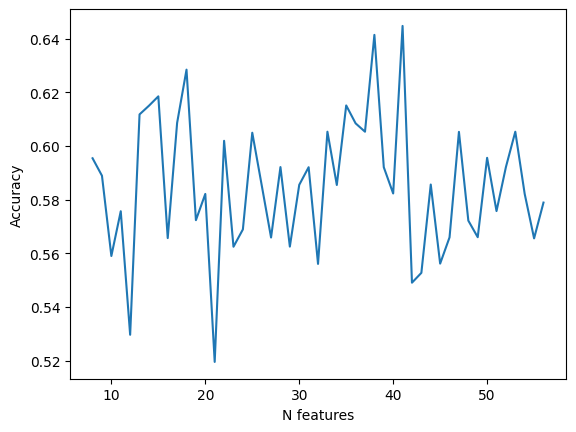

In [50]:
# best classifier is Random Forest 

# lets tune 

from sklearn.feature_selection import RFE

acc_results = []
n_features = []

rdmf = RandomForestClassifier(max_depth=150, random_state=25)

for i in range(8, 57):
    rfe = RFE(estimator = rdmf, n_features_to_select = i, step=1)
    rfe.fit(X, y)
    X_temp = rfe.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_temp,y, test_size = 0.2)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    start = time.time()
    scores = cross_val_score(rdmf, X_train, y_train ,scoring= 'accuracy', cv=5)
    print(" rdmf result :", "%0.3f, +- %0.3f" % (scores.mean(), scores.std()), 'N_features :', i)
    acc_results.append(scores.mean())
    n_features.append(i)

plt.plot(n_features, acc_results)
plt.ylabel('Accuracy')
plt.xlabel('N features')
plt.show()

In [54]:
rfe = RFE(estimator = rdmf, n_features_to_select = 13, step=1)
rfe.fit(X, y)
X_transformed = rfe.transform(X)

np.random.seed(50)

X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, test_size = 0.2)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


featured_columns = pd.DataFrame(rfe.support_,
                            index = X.columns,
                            columns=['is_in'])

featured_columns = featured_columns[featured_columns.is_in == True].index.tolist()

In [55]:
featured_columns

['Big Chances_2_home',
 'Corners Taken_4_home',
 'Expected Goals Conceded_5_home',
 'Possession (%)_9_home',
 'FotMob Team Rating_11_home',
 'Touches in Opposition Box_12_home',
 'Big Chances Missed_1_away',
 'Big Chances_2_away',
 'Goals_2_away',
 'Corners Taken_4_away',
 'Possession (%)_9_away',
 'Total Possessions Won_10_away',
 'Successful Tackles per Match_14_away']

In [61]:
# Grid Search 

param_grid = {
        # Number of trees in the forest
        'n_estimators': [50, 100, 200],
        
        # Maximum depth of the trees
        'max_depth': [None, 10, 20, 30],
        
        # Minimum number of samples required to split an internal node
        'min_samples_split': [2, 5, 10],
        
        # Minimum number of samples required to be at a leaf node
        'min_samples_leaf': [1, 2, 4],
        
        # Number of features to consider when looking for the best split
        'max_features': ['sqrt', 'log2', None],
        
        # Method of selecting samples for training each tree
        'bootstrap': [True, False]
    }

rf = RandomForestClassifier(random_state=25)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Don't show progress
    scoring='accuracy'  # Metric to optimize
)


grid_search.fit(X_train, y_train)
    
# Best model
best_rf = grid_search.best_estimator_
    
# Detailed results
cv_results = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estim

In [63]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.222534,0.053847,0.011842,0.003688,True,None,sqrt,1,2,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.598039,0.554455,0.584158,0.578884,0.018180,379
1,0.310662,0.021586,0.011935,0.000516,True,None,sqrt,1,2,100,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.578431,0.564356,0.574257,0.572348,0.005902,433
2,0.696607,0.061214,0.028520,0.011061,True,None,sqrt,1,2,200,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.549020,0.554455,0.554455,0.552643,0.002562,517
3,0.172220,0.023054,0.006128,0.000458,True,None,sqrt,1,5,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.588235,0.594059,0.603960,0.595418,0.006491,60
4,0.324232,0.043082,0.014698,0.005011,True,None,sqrt,1,5,100,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.578431,0.603960,0.594059,0.592150,0.010509,122


In [64]:
y_pred=best_rf.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.13      0.18        15
           1       0.72      0.87      0.79        53
           2       0.00      0.00      0.00         9

    accuracy                           0.62        77
   macro avg       0.33      0.33      0.32        77
weighted avg       0.55      0.62      0.58        77

[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_